# D&D Gameplay Log Analysis Tutorial

This notebook demonstrates how to analyze Dungeons & Dragons gameplay logs using the `dnd_analysis.py` module. We'll load campaign data from `data-labels.json`, select a specific campaign for analysis, and perform various analyses to understand player engagement patterns and campaign dynamics.

## 🎯 Campaign Selection

**NEW: User-Selectable Campaign Analysis**
- This notebook now analyzes campaigns from the `data-labels.json` dataset
- **Change the `CAMPAIGN_INDEX` in the Configuration cell** to analyze different campaigns
- The dataset contains hundreds of campaigns - you can analyze any of them!
- All analysis functions work with the selected campaign data

## Table of Contents
1. [Configuration & Campaign Selection](#config)
2. [Data Loading and Preparation](#loading)
3. [Time Interval Analysis](#intervals)
4. [Cumulative Post Analysis](#cumulative)
5. [Player and Character Growth](#growth)
6. [Post Length Analysis](#lengths)
7. [Action vs Dialogue Analysis](#action-dialogue)
8. [Character Mention Analysis](#mentions)
9. [Dice Roll Analysis](#dice-rolls)
10. [Summary Report](#summary)

In [22]:
# Import required libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm  
import seaborn as sns
import numpy as np
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import our analysis module
import dnd_analysis as dnd

# Set up plotting style
plt.style.use('default')
sns.color_palette("mako")
plt.rcParams['figure.dpi'] = 100

# Create Plots directory
plots_dir = Path('Plots')
plots_dir.mkdir(exist_ok=True)
print(f"Created plots directory: {plots_dir}")

# Helper function for saving plots
def save_plot(filename):
    
    filepath = plots_dir / filename
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")

print("Libraries imported successfully!")

Created plots directory: Plots
Libraries imported successfully!


## Configuration & Campaign Selection {#config}

**Step 1: Choose Your Campaign**
Change the `CAMPAIGN_INDEX` below to analyze different campaigns from the dataset. The index starts at 0 for the first campaign, 1 for the second, etc.

In [ ]:
# Configuration - Change this to analyze different campaigns
CAMPAIGN_INDEX = 0  # Default to first campaign, user can change this number

print(f"📊 CAMPAIGN SELECTION CONFIG")
print(f"Selected campaign index: {CAMPAIGN_INDEX}")
print(f"Note: You can change CAMPAIGN_INDEX above to analyze different campaigns (0, 1, 2, etc.)")

# Load all campaigns from data-labels.json
json_file_path = 'Game-Data/data-labels.json'

try:
    with open(json_file_path, 'r', encoding='utf-8') as f:
        all_campaigns = json.load(f)
    print(f"✅ Successfully loaded data from {json_file_path}")
except FileNotFoundError:
    print(f"❌ File not found: {json_file_path}")
    print("Please ensure the data-labels.json file exists in the Game-Data/ directory")
    raise

# Get list of campaign IDs
campaign_ids = list(all_campaigns.keys())
print(f"📚 Found {len(campaign_ids)} campaigns in dataset")

# Display available campaigns for reference
print(f"\n📋 Available campaigns:")
for i, campaign_id in enumerate(campaign_ids[:10]):  # Show first 10
    campaign_preview = campaign_id[:50] + "..." if len(campaign_id) > 50 else campaign_id
    print(f"  [{i}] {campaign_preview}")
if len(campaign_ids) > 10:
    print(f"  ... and {len(campaign_ids) - 10} more campaigns")

# Validate campaign index
if CAMPAIGN_INDEX >= len(campaign_ids):
    raise ValueError(f"❌ Campaign index {CAMPAIGN_INDEX} out of range. Max index: {len(campaign_ids)-1}")
if CAMPAIGN_INDEX < 0:
    raise ValueError(f"❌ Campaign index must be >= 0")

# Select specific campaign
selected_campaign_id = campaign_ids[CAMPAIGN_INDEX]
selected_campaign_data = {selected_campaign_id: all_campaigns[selected_campaign_id]}

print(f"\n🎯 SELECTED CAMPAIGN")
print(f"Campaign ID: {selected_campaign_id}")
print(f"Number of messages: {len(all_campaigns[selected_campaign_id])}")

# Convert selected campaign to DataFrame
df = dnd.load_dnd_data(selected_campaign_data)

print(f"\n📊 DATAFRAME CREATED")
print(f"Messages loaded: {len(df)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Unique players: {df['player'].nunique()}")
print(f"Unique characters: {df['character'].nunique()}")

# Display first few rows
print("\n📝 First 5 rows of the DataFrame:")
df.head()

In [23]:
# Load JSON data
# Note: Update this path to point to your actual data file
json_file_path = 'Game-Data/phandelver-labels.json'

try:
    with open(json_file_path, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    print(f"Successfully loaded JSON data from {json_file_path}")
except FileNotFoundError:
    print(f"File not found: {json_file_path}")
    print("Please update the path to your JSON file or create sample data")
    # Create sample data for demonstration
    json_data = {
        "sample-campaign": {
            "1": {
                "date": "2019-03-18T06:19:37",
                "player": "DM",
                "character": "Dungeon Master",
                "text": "Welcome to the adventure!",
                "actions": {},
                "name_mentions": [],
                "in_combat": False
            },
            "2": {
                "date": "2019-03-18T07:20:15",
                "player": "Player1",
                "character": "Aragorn",
                "text": "I look around carefully.",
                "actions": {"check": {"roll": ["15"]}},
                "name_mentions": ["Aragorn"],
                "in_combat": False
            }
        }
    }
    print("Using sample data for demonstration")

# Convert to DataFrame
df = dnd.load_dnd_data(json_data)

print(f"\nDataFrame created with {len(df)} messages")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Unique players: {df['player'].nunique()}")
print(f"Unique characters: {df['character'].nunique()}")
print(f"Campaigns: {df['campaign_id'].nunique()}")

# Display first few rows
print("\nFirst 5 rows of the DataFrame:")
df.head()

Successfully loaded JSON data from Game-Data/phandelver-labels.json

DataFrame created with 4289 messages
Date range: 2019-03-18 06:19:37 to 2020-07-30 17:15:19
Unique players: 7
Unique characters: 6
Campaigns: 1

First 5 rows of the DataFrame:


,campaign_id,message_id,date,player,character,text,in_combat,name_mentions,actions,gender,race,class,inventory,word_count,has_dice_roll,message_type
0,35444-lost-mines-lost-labs-and-lost-hope-robjf...,1,2019-03-18 06:19:37,RobJFalcon,Dungeon Master,"You are in the city of Neverwinter , where a d...",False,"[Sildar, Gundren, Phandalin]",{},None,None,None,[],361,False,action
1,35444-lost-mines-lost-labs-and-lost-hope-robjf...,2,2019-03-18 12:52:54,GeneralSanspants,Az Emberi,I am Az Emberi. ( 6 foot lean. Young looks abo...,False,[Az Emberi],{},male,elf,wizard,"[club, pack, rope]",41,False,action
2,35444-lost-mines-lost-labs-and-lost-hope-robjf...,3,2019-03-18 14:38:40,Gallowscall,Fjolnir,"""Mornin fellers."" The Dwarf cocks his head to ...",False,[Fjolnir],{},male,dwarf,bard,[],96,False,dialogue
3,35444-lost-mines-lost-labs-and-lost-hope-robjf...,4,2019-03-18 15:32:55,GeneralSanspants,Az Emberi,I met Gundren in a bar. He was drunk dnd fell ...,False,[Gundren],{},male,elf,wizard,"[club, pack, rope]",29,False,narrative
4,35444-lost-mines-lost-labs-and-lost-hope-robjf...,5,2019-03-18 15:34:47,GeneralSanspants,Az Emberi,I will drive the cart if no one else wishes to...,False,[],{},male,elf,wizard,"[club, pack, rope]",13,False,narrative


In [ ]:
# Campaign Information Helper
print("🗂️  CAMPAIGN INFORMATION HELPER")
print("="*50)

print(f"\n📈 DATASET OVERVIEW:")
print(f"  Total campaigns available: {len(campaign_ids)}")
print(f"  Currently analyzing campaign: {CAMPAIGN_INDEX}")

# Show basic stats for the first few campaigns to help users choose
print(f"\n📊 CAMPAIGN PREVIEW (first 5 campaigns):")
for i, campaign_id in enumerate(campaign_ids[:5]):
    try:
        campaign_messages = all_campaigns[campaign_id]
        msg_count = len(campaign_messages)
        
        # Quick preview of first message to get date range idea
        first_msg = next(iter(campaign_messages.values()))
        first_date = first_msg.get('date', 'Unknown')
        
        campaign_name = campaign_id[:40] + "..." if len(campaign_id) > 40 else campaign_id
        status = "◀── SELECTED" if i == CAMPAIGN_INDEX else ""
        print(f"  [{i}] {campaign_name}")
        print(f"      Messages: {msg_count}, Start: {first_date[:10]} {status}")
    except Exception as e:
        print(f"  [{i}] {campaign_id[:40]}... (Error reading: {str(e)[:30]})")

if len(campaign_ids) > 5:
    print(f"  ... and {len(campaign_ids) - 5} more campaigns")

print(f"\n💡 TO CHANGE CAMPAIGNS:")
print(f"  1. Go to the Configuration cell at the top")
print(f"  2. Change CAMPAIGN_INDEX to desired number (0 to {len(campaign_ids)-1})")
print(f"  3. Re-run all cells from the Configuration cell onward")

print(f"\n✅ Currently analyzing campaign [{CAMPAIGN_INDEX}]: {selected_campaign_id[:60]}{'...' if len(selected_campaign_id) > 60 else ''}")

In [24]:
# Data validation and overview
print("=== DATA VALIDATION ===")
print(f"Total messages: {len(df)}")
print(f"Missing dates: {df['date'].isna().sum()}")
print(f"Missing players: {df['player'].isna().sum()}")
print(f"Missing characters: {df['character'].isna().sum()}")
print(f"Missing text: {df['text'].isna().sum()}")

print("\n=== BASIC STATISTICS ===")
print(f"Average words per post: {df['word_count'].mean():.1f}")
print(f"Posts with dice rolls: {df['has_dice_roll'].sum()} ({df['has_dice_roll'].mean()*100:.1f}%)")
print(f"Posts in combat: {df['in_combat'].sum()} ({df['in_combat'].mean()*100:.1f}%)")

print("\n=== MESSAGE TYPE DISTRIBUTION ===")
print(df['message_type'].value_counts())

print("\n=== TOP PLAYERS BY POST COUNT ===")
print(df['player'].value_counts().head(10))

=== DATA VALIDATION ===
Total messages: 4289
Missing dates: 0
Missing players: 0
Missing characters: 0
Missing text: 0

=== BASIC STATISTICS ===
Average words per post: 59.9
Posts with dice rolls: 1139 (26.6%)
Posts in combat: 1739 (40.5%)

=== MESSAGE TYPE DISTRIBUTION ===
message_type
action       2526
dialogue      993
narrative     770
Name: count, dtype: int64

=== TOP PLAYERS BY POST COUNT ===
player
RobJFalcon          1162
Evildrive            732
GeneralSanspants     674
Gallowscall          518
CashlessRegent       416
Nockturen            407
DebatableLogic       380
Name: count, dtype: int64


## Time Interval Analysis {#intervals}

Let's analyze the time intervals between consecutive posts to understand posting patterns and player engagement rhythms.

=== OVERALL TIME INTERVALS ===
Mean interval: 2.80 hours
Median interval: 0.63 hours
Saved: Plots/time_intervals_overall.png


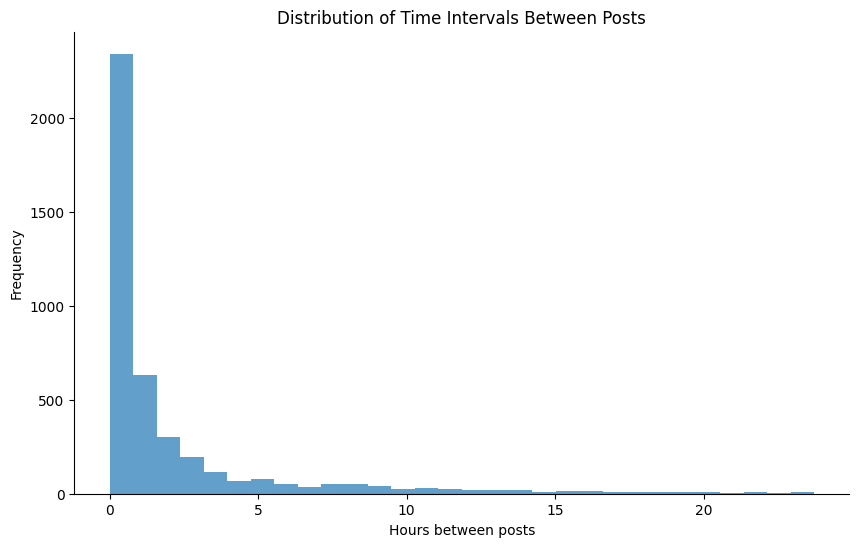

In [25]:
# Overall time intervals analysis
print("=== OVERALL TIME INTERVALS ===")
overall_intervals = dnd.analyze_time_intervals(df, by_player=False)
print(f"Mean interval: {overall_intervals['overall']['mean_hours']:.2f} hours")
print(f"Median interval: {overall_intervals['overall']['median_hours']:.2f} hours")

# Plot overall intervals
plt.figure(figsize=(10, 6))
intervals_data = overall_intervals['overall']['intervals_data']
plt.hist(intervals_data, bins=30, alpha=0.7, edgecolor='none', linewidth=0.5)
plt.title('Distribution of Time Intervals Between Posts')
plt.xlabel('Hours between posts')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
save_plot('time_intervals_overall.png')
plt.show()

In [ ]:
# Time intervals by player
print("\n=== TIME INTERVALS BY PLAYER ===")
player_intervals = dnd.analyze_time_intervals(df, by_player=True)

# Print statistics for all players
for player, stats in player_intervals.items():
    print(f"{player}: {stats['mean_hours']:.2f} hours (median: {stats['median_hours']:.2f}h, n={stats['count']})")

# Plot intervals by player - create subplots based on number of players
if len(player_intervals) > 0:
    n_players = len(player_intervals)
    n_cols = min(3, n_players)  # Max 3 columns
    n_rows = (n_players + n_cols - 1) // n_cols  # Calculate rows needed
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    if n_players == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if n_players > 1 else [axes]
    else:
        axes = axes.ravel()
    
    for i, (player, stats) in enumerate(player_intervals.items()):
        intervals_data = stats['intervals_data']
        axes[i].hist(intervals_data, bins=20, alpha=0.7, edgecolor='none', linewidth=0.5)
        axes[i].set_title(f'{player} (n={stats["count"]})')
        axes[i].set_xlabel('Hours between posts')
        axes[i].set_ylabel('Frequency')
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
    
    # Hide unused subplots
    for i in range(n_players, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Time Intervals Between Posts by Player', y=1.02)
    save_plot('time_intervals_by_player.png')
    plt.show()

## Cumulative Post Analysis {#cumulative}

Track how posting activity accumulates over time, both overall and per player.

=== CUMULATIVE POSTS OVER TIME ===
Total posts in dataset: 4289
Saved: Plots/cumulative_posts_overall.png


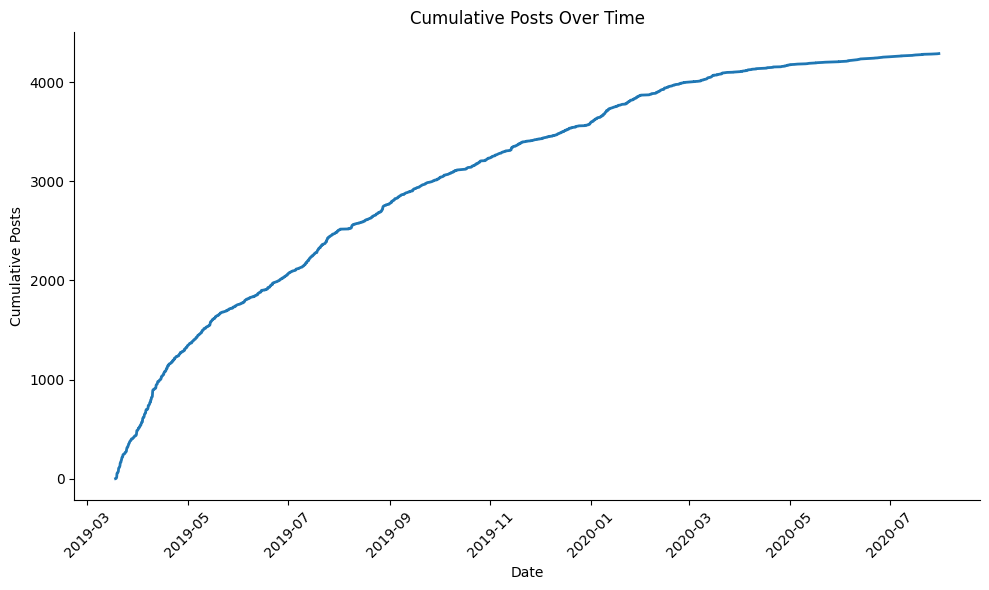

In [27]:
# Overall cumulative posts
print("=== CUMULATIVE POSTS OVER TIME ===")
cumulative_overall = dnd.analyze_cumulative_posts(df, by_player=False)
print(f"Total posts in dataset: {len(cumulative_overall['cumulative_posts'])}")

# Plot overall cumulative posts
plt.figure(figsize=(10, 6))
plt.plot(cumulative_overall['dates'], cumulative_overall['cumulative_posts'], linewidth=2)
plt.title('Cumulative Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Posts')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.tight_layout()
save_plot('cumulative_posts_overall.png')
plt.show()


=== CUMULATIVE POSTS BY PLAYER ===
Final post counts by player:
  RobJFalcon: 1162 posts
  Evildrive: 732 posts
  GeneralSanspants: 674 posts
  Gallowscall: 518 posts
  CashlessRegent: 416 posts
  Nockturen: 407 posts
  DebatableLogic: 380 posts
Saved: Plots/cumulative_posts_by_player.png


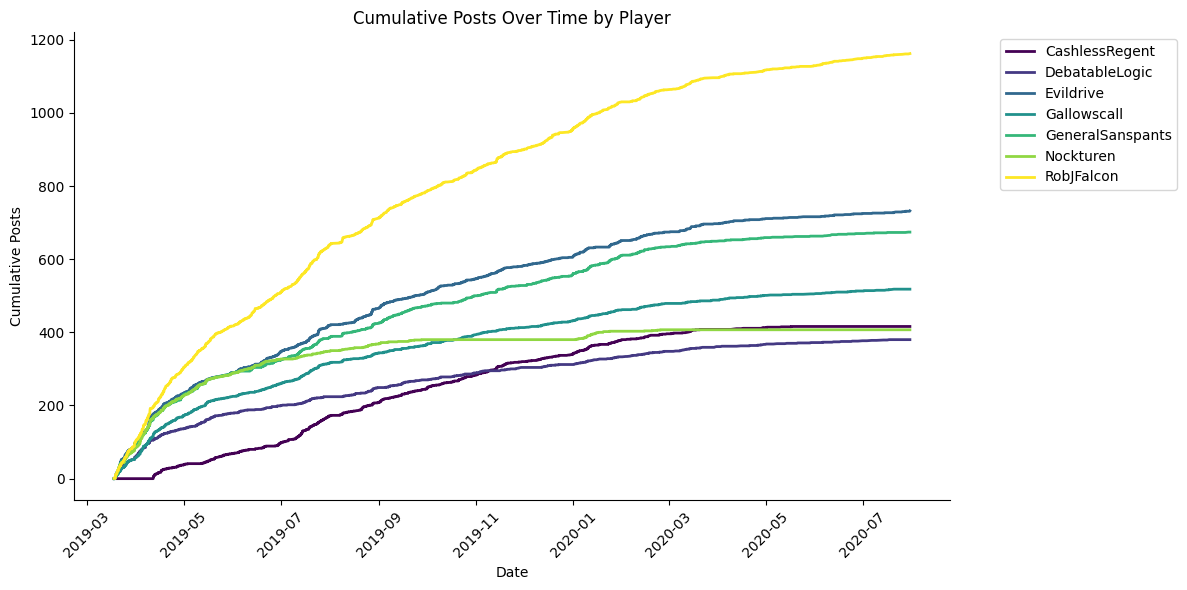

In [28]:
# Cumulative posts by player
print("\n=== CUMULATIVE POSTS BY PLAYER ===")
cumulative_by_player = dnd.analyze_cumulative_posts(df, by_player=True)

if cumulative_by_player['type'] == 'by_player':
    # Print final counts
    final_counts = cumulative_by_player['data'].iloc[-1]
    print(f"Final post counts by player:")
    for player, count in final_counts.sort_values(ascending=False).head(10).items():
        print(f"  {player}: {count} posts")
    
    players      = cumulative_by_player['players']
    n_players    = len(players)
    cmap         = cm.get_cmap("viridis", n_players)          # perceptual colormap
    colours      = cmap(np.linspace(0, 1, n_players))         # N evenly-spaced colours

    # Plot cumulative posts by player
    plt.figure(figsize=(12, 6))
    for player in cumulative_by_player['players']:
        plt.plot(cumulative_by_player['dates'], cumulative_by_player['data'][player], 
                label=player, linewidth=2, color=colours[players.index(player)])
    
    plt.title('Cumulative Posts Over Time by Player')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Posts')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    save_plot('cumulative_posts_by_player.png')
    plt.show()

## Player and Character Growth {#growth}

Analyze how the number of unique players and characters grows over the campaign timeline.

=== PLAYER AND CHARACTER GROWTH ===
Final unique players: 7
Final unique characters: 6

Growth milestones:
  First day: 1 players, 1 characters
  Midpoint: 7 players, 6 characters
  Final: 7 players, 6 characters
Saved: Plots/unique_players_characters.png


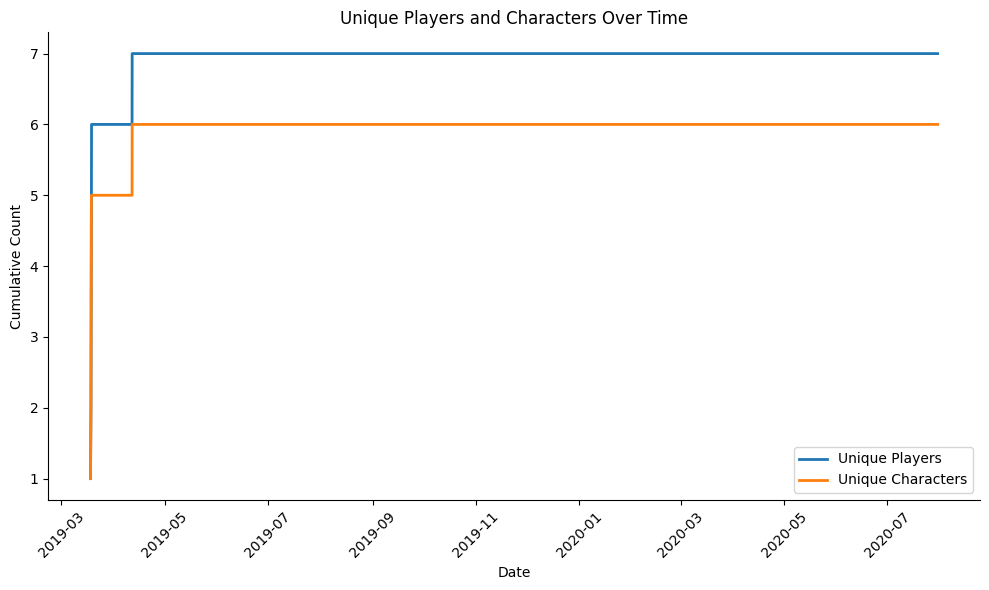

In [29]:
# Unique players and characters over time
print("=== PLAYER AND CHARACTER GROWTH ===")
growth_data = dnd.analyze_unique_players_characters(df)
print(f"Final unique players: {growth_data['final_unique_players']}")
print(f"Final unique characters: {growth_data['final_unique_characters']}")

# Show growth milestones
unique_players = growth_data['unique_players_cumulative']
unique_characters = growth_data['unique_characters_cumulative']
print(f"\nGrowth milestones:")
print(f"  First day: {unique_players[0]} players, {unique_characters[0]} characters")
print(f"  Midpoint: {unique_players[len(unique_players)//2]} players, {unique_characters[len(unique_characters)//2]} characters")
print(f"  Final: {unique_players[-1]} players, {unique_characters[-1]} characters")

# Plot unique players and characters growth
plt.figure(figsize=(10, 6))
plt.plot(growth_data['dates'], growth_data['unique_players_cumulative'], 
         label='Unique Players', linewidth=2)
plt.plot(growth_data['dates'], growth_data['unique_characters_cumulative'], 
         label='Unique Characters', linewidth=2)
plt.title('Unique Players and Characters Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Count')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.tight_layout()
save_plot('unique_players_characters.png')
plt.show()

## Post Length Analysis {#lengths}

Examine the distribution of post lengths (word counts) to understand communication patterns.

=== OVERALL POST LENGTH STATISTICS ===
Mean words per post: 59.9
Median words per post: 34.0
Standard deviation: 79.7
Longest post: 916 words
Saved: Plots/post_lengths_overall.png


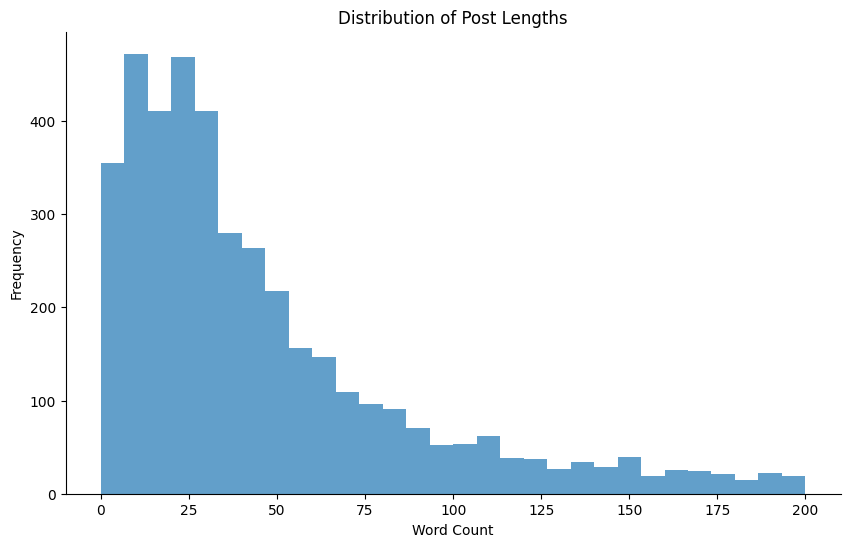

In [30]:
# Overall post length analysis
print("=== OVERALL POST LENGTH STATISTICS ===")
overall_lengths = dnd.analyze_post_lengths(df, by_player=False)
stats = overall_lengths['overall']
print(f"Mean words per post: {stats['mean_words']:.1f}")
print(f"Median words per post: {stats['median_words']:.1f}")
print(f"Standard deviation: {stats['std_words']:.1f}")
print(f"Longest post: {stats['max_words']} words")

# Plot overall post lengths
plt.figure(figsize=(10, 6))
word_counts_data = stats['word_counts_data']
plt.hist(word_counts_data, bins=30, alpha=0.7, edgecolor='none', linewidth=0.5)
plt.title('Distribution of Post Lengths')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
save_plot('post_lengths_overall.png')
plt.show()

In [ ]:
# Post length by player
print("\n=== POST LENGTH BY ALL PLAYERS ===")
player_lengths = dnd.analyze_post_lengths(df, by_player=True)

# Print statistics for all players
for player, stats in player_lengths.items():
    if player != 'overall':
        print(f"{player}: {stats['mean_words']:.1f} words average (n={stats['count']})")

# Plot post lengths by player - create subplots based on number of players
if len(player_lengths) > 0:
    n_players = len(player_lengths)
    n_cols = min(3, n_players)  # Max 3 columns
    n_rows = (n_players + n_cols - 1) // n_cols  # Calculate rows needed
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    if n_players == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if n_players > 1 else [axes]
    else:
        axes = axes.ravel()

    for i, (player, stats) in enumerate(player_lengths.items()):
        word_counts_data = stats['word_counts_data']
        axes[i].hist(word_counts_data, bins=20, alpha=0.7, edgecolor='none', linewidth=0.5)
        axes[i].set_title(f'{player} (n={stats["count"]})')
        axes[i].set_xlabel('Word Count')
        axes[i].set_ylabel('Frequency')
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
    
    # Hide unused subplots
    for i in range(n_players, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle('Post Length Distribution by Player', y=1.02)
    save_plot('post_lengths_by_player.png')
    plt.show()

## Action vs Dialogue Analysis {#action-dialogue}

Classify posts as action-related, dialogue, or narrative to understand gameplay dynamics.

In [ ]:
# Action vs dialogue analysis
print("=== ACTION VS DIALOGUE ANALYSIS ===")
action_dialogue_data = dnd.analyze_action_vs_dialogue(df)

print(f"Total posts: {action_dialogue_data['total_posts']}")
print(f"Action posts: {action_dialogue_data['action_posts']} ({action_dialogue_data['action_percentage']:.1f}%)")
print(f"Dialogue posts: {action_dialogue_data['dialogue_posts']} ({action_dialogue_data['dialogue_percentage']:.1f}%)")
print(f"Narrative posts: {action_dialogue_data['narrative_posts']}")

# Show daily trends if available
daily_data = action_dialogue_data['daily_data']
if len(daily_data) > 1:
    print(f"\nDaily averages:")
    for msg_type in daily_data.columns:
        avg_daily = daily_data[msg_type].mean()
        print(f"  {msg_type.title()}: {avg_daily:.1f} posts/day")

# Plot action vs dialogue over time
if len(action_dialogue_data['rolling_data']) > 0:
    plt.figure(figsize=(12, 6))
    
    rolling_data = action_dialogue_data['rolling_data']
    for msg_type in rolling_data.columns:
        plt.plot(rolling_data.index, rolling_data[msg_type], 
                label=msg_type.title(), linewidth=2)
    
    plt.title('Message Types Over Time (Rolling Average)')
    plt.xlabel('Date')
    plt.ylabel('Average Posts per Day')
    plt.legend()
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    save_plot('action_vs_dialogue.png')
    plt.show()

## Character Mention Analysis {#mentions}

Identify the most frequently mentioned character names to understand story focus and important NPCs.

In [ ]:
# Character mention analysis
print("=== CHARACTER MENTION ANALYSIS ===")
mention_data = dnd.analyze_character_mentions(df, top_n=15)

print(f"Total mentions: {mention_data['total_mentions']}")
print(f"Unique characters mentioned: {mention_data['unique_characters_mentioned']}")

print(f"\nTop 10 most mentioned characters:")
for i, (character, count) in enumerate(list(mention_data['top_mentions'].items())[:10], 1):
    print(f"  {i:2d}. {character}: {count} mentions")

# Plot character mentions
if len(mention_data['top_mentions_names']) > 0:
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(mention_data['top_mentions_names'])), 
                   mention_data['top_mentions_counts'], alpha=0.7)
    plt.title(f'Top {len(mention_data["top_mentions_names"])} Most Mentioned Characters')
    plt.xlabel('Character Name')
    plt.ylabel('Mention Count')
    plt.xticks(range(len(mention_data['top_mentions_names'])), 
               mention_data['top_mentions_names'], rotation=45, ha='right')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Add value labels on bars
    for bar, value in zip(bars, mention_data['top_mentions_counts']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(value), ha='center', va='bottom')
    
    plt.tight_layout()
    save_plot('character_mentions.png')
    plt.show()

## Dice Roll Analysis {#dice-rolls}

Analyze the frequency of dice rolls to understand mechanical vs. narrative gameplay balance.

In [ ]:
# Dice roll analysis
print("=== DICE ROLL ANALYSIS ===")
dice_data = dnd.analyze_dice_roll_frequency(df)

print(f"Total posts: {dice_data['total_posts']}")
print(f"Posts with dice rolls: {dice_data['posts_with_rolls']} ({dice_data['roll_percentage']:.1f}%)")

print(f"\nDice roll frequency by player:")
for player_stat in dice_data['player_stats']:
    player = player_stat['player']
    percentage = player_stat['percentage']
    count = player_stat['count']
    rolls = player_stat['sum']
    print(f"  {player}: {rolls}/{count} posts ({percentage:.1f}%)")

# Create dice roll visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Overall pie chart
ax1.pie([dice_data['posts_with_rolls'], dice_data['posts_without_rolls']], 
        labels=['With Dice Rolls', 'Without Dice Rolls'],
        autopct='%1.1f%%', startangle=90)
ax1.set_title('Posts with Dice Rolls')

# Dice roll percentage by player
if len(dice_data['player_names']) > 0:
    bars = ax2.bar(range(len(dice_data['player_names'])), 
                   dice_data['player_percentages'], alpha=0.7)
    ax2.set_title('Dice Roll Percentage by Player')
    ax2.set_xlabel('Player')
    ax2.set_ylabel('Percentage of Posts with Rolls')
    ax2.set_xticks(range(len(dice_data['player_names'])))
    ax2.set_xticklabels(dice_data['player_names'], rotation=45, ha='right')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Add value labels
    for bar, value in zip(bars, dice_data['player_percentages']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}%', ha='center', va='bottom')

plt.tight_layout()
save_plot('dice_roll_frequency.png')
plt.show()

# Time series plot
if len(dice_data['daily_dates']) > 1:
    plt.figure(figsize=(12, 6))
    plt.plot(dice_data['daily_dates'], dice_data['daily_percentages'], linewidth=2)
    plt.title('Dice Roll Percentage Over Time')
    plt.xlabel('Date')
    plt.ylabel('Percentage of Posts with Dice Rolls')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    save_plot('dice_roll_timeseries.png')
    plt.show()

## Summary Report {#summary}

Generate a comprehensive overview of the entire campaign for quick insights.

In [33]:
# Generate comprehensive summary report
print("=== COMPREHENSIVE CAMPAIGN SUMMARY ===")
summary = dnd.generate_summary_report(df)

print("\n📊 CAMPAIGN OVERVIEW")
overview = summary['campaign_overview']
print(f"  📅 Duration: {overview['date_range']}")
print(f"  📝 Total posts: {overview['total_posts']}")
print(f"  👥 Unique players: {overview['unique_players']}")
print(f"  🎭 Unique characters: {overview['unique_characters']}")
print(f"  📈 Posts per day: {overview['posts_per_day']:.1f}")

print("\n📝 POSTING PATTERNS")
patterns = summary['posting_patterns']
print(f"  🏆 Most active player: {patterns['most_active_player']} ({patterns['posts_by_most_active']} posts)")
print(f"  📏 Average post length: {patterns['average_post_length']:.1f} words")
print(f"  📚 Longest post: {patterns['longest_post_words']} words")

print("\n🎮 GAMEPLAY CHARACTERISTICS")
gameplay = summary['gameplay_characteristics']
print(f"  🎲 Dice roll frequency: {gameplay['dice_roll_percentage']:.1f}%")
print(f"  ⚔️ Action posts: {gameplay['action_percentage']:.1f}%")
print(f"  💬 Dialogue posts: {gameplay['dialogue_percentage']:.1f}%")
print(f"  ⚔️ Combat posts: {gameplay['combat_posts']} ({gameplay['combat_percentage']:.1f}%)")

print("\n✅ Analysis complete! All plots have been saved as PNG files.")

=== COMPREHENSIVE CAMPAIGN SUMMARY ===

📊 CAMPAIGN OVERVIEW
  📅 Duration: 2019-03-18 to 2020-07-30
  📝 Total posts: 4289
  👥 Unique players: 7
  🎭 Unique characters: 6
  📈 Posts per day: 8.6

📝 POSTING PATTERNS
  🏆 Most active player: RobJFalcon (1162 posts)
  📏 Average post length: 59.9 words
  📚 Longest post: 916 words

🎮 GAMEPLAY CHARACTERISTICS
  🎲 Dice roll frequency: 26.6%
  ⚔️ Action posts: 58.9%
  💬 Dialogue posts: 23.2%
  ⚔️ Combat posts: 1739 (40.5%)

✅ Analysis complete! All plots have been saved as PNG files.


## Conclusion

This tutorial demonstrated how to use the `dnd_analysis.py` module to analyze D&D gameplay logs. The analysis provides insights into:

- **Player engagement patterns** through time intervals and posting frequency
- **Campaign growth** via player and character introduction over time  
- **Communication styles** through post length distributions
- **Gameplay balance** between action, dialogue, and narrative elements
- **Story elements** via character mention frequency
- **Mechanical vs. narrative focus** through dice roll analysis

### Generated Files

All visualizations have been saved as PNG files in the `Plots/` directory:
- `time_intervals_overall.png` / `time_intervals_by_player.png`
- `cumulative_posts_overall.png` / `cumulative_posts_by_player.png`
- `unique_players_characters.png`
- `post_lengths_overall.png` / `post_lengths_by_player.png`
- `action_vs_dialogue.png`
- `character_mentions.png`
- `dice_roll_frequency.png` / `dice_roll_timeseries.png`

### Next Steps

You can extend this analysis by:
- Adding sentiment analysis to character dialogue
- Analyzing inventory changes over time
- Correlating dice roll outcomes with story progression
- Building predictive models for player engagement
- Creating interactive dashboards with plotly/dash

### Customizing Plots

The separation of analysis and visualization allows you to easily customize plots:
- Change colors, styles, and themes
- Add statistical overlays (mean lines, confidence intervals)
- Create different plot types (scatter, violin, box plots)
- Build interactive visualizations with plotly
- Export to different formats (PDF, SVG, etc.)